# 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

# 1. Classifying players as offensive or deffensive

### 1.1 Building and Evaluating model with forwards and defenders: Decision Tree Classifier

In order to train and test the model, we use only the players that are forwards or defenders as we can easily label them as offensive (forwards) and deffensive (defenders) players.

In [2]:
#Read tables and drop unnecesary columns:
players = pd.read_csv(r'datacsv/player.csv').drop(columns=['team_name', 'birth_year'])
goals = pd.read_csv(r'datacsv/goal.csv')
cards = pd.read_csv(r'datacsv/card.csv')

#Combine tables, adding cards_received and goals_scores to players and removing player name:
players["cards_received"] = 0
for card_index, card_row in cards.iterrows():
    pindex = players.loc[players['player_name'] == card_row.player_name].index
    players.at[pindex[0],'cards_received'] +=1

players["goals_scored"] = 0
for goal_index, goal_row in goals.iterrows():
    pindex = players.loc[players['player_name'] == goal_row.player_name].index
    players.at[pindex[0],'goals_scored'] +=1

players = players.drop(columns=['player_name'])

players.head()

,nationality,position,number,cards_received,goals_scored
0,Spanish,Goalkeeper,1,0,0
1,Spanish,Goalkeeper,13,1,0
2,Spanish,Goalkeeper,25,2,0
3,Spanish,Defender,3,4,0
4,Spanish,Defender,4,12,0


In [3]:
#Retrieving only forwards and defenfers to build classifier (removing goalkeepers and miedfielders):
playersForDef = players.drop(players[players['position'] == 'Goalkeeper'].index)
playersForDef = playersForDef.drop(playersForDef[playersForDef['position'] == 'Midfielder'].index)
playersForDefIndex = playersForDef.index

#Retrieving midfielders for later...
playersMid = players.drop(players[players['position'] == 'Goalkeeper'].index)
playersMid = playersMid.drop(playersMid[playersMid['position'] == 'Forward'].index)
playersMid = playersMid.drop(playersMid[playersMid['position'] == 'Defender'].index)
playersMidIndex = playersMid.index

#Preprocess categorical values to encode them!
le = LabelEncoder()
players[['nationality']] = players[['nationality']].apply(le.fit_transform)
le_nationality_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_nationality_mapping)

players[['position']] = players[['position']].apply(le.fit_transform)
le_pos_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(le_pos_mapping)

playersForDef = players.loc[playersForDefIndex]


{0: 'Algerian', 1: 'Argentinian', 2: 'Argetinian', 3: 'Austrian', 4: 'Belgian', 5: 'Bosnian', 6: 'Brazilian', 7: 'Cameroonian', 8: 'Central African', 9: 'Chilean', 10: 'Chinese', 11: 'Coastarican', 12: 'Colombian', 13: 'Congolese', 14: 'Costa Rican', 15: 'Croatian', 16: 'Czech', 17: 'Danish', 18: 'Dominican', 19: 'Dutch', 20: 'Ecuadorian', 21: 'English', 22: 'French', 23: 'German', 24: 'Ghanaian', 25: 'Greek', 26: 'Guinean', 27: 'Italian', 28: 'Ivorian', 29: 'Japanese', 30: 'Macedonian', 31: 'Mexican', 32: 'Montenegrin', 33: 'Moroccan', 34: 'Nigerian', 35: 'Paraguayan', 36: 'Peruvian', 37: 'Polish', 38: 'Portuguese', 39: 'Romanian', 40: 'Russian', 41: 'Senegalese', 42: 'Serbian', 43: 'Slovak', 44: 'Slovenian', 45: 'South Korean', 46: 'Spanish', 47: 'Swedish', 48: 'Togolese', 49: 'Turkish', 50: 'Turquish', 51: 'Ukrainian', 52: 'Uruguayan', 53: 'Venezuelan', 54: 'Welsh'}
{0: 'Defender', 1: 'Forward', 2: 'Goalkeeper', 3: 'Midfielder'}


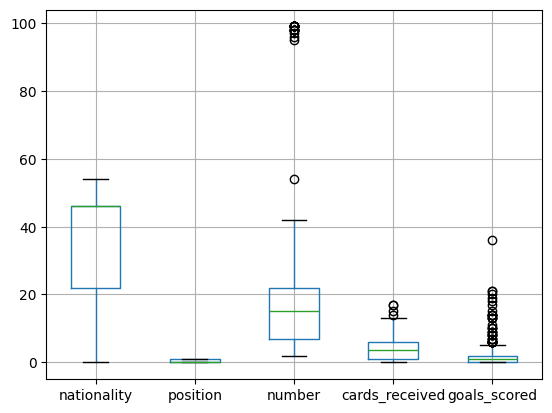

Number of instances in playersForDef before removing outliers = 292
Number of instances in playersForDef after removing outliers = 261


In [4]:
# #show boxplot to detect outliers
playersForDef.boxplot()
plt.show()

print('Number of instances in playersForDef before removing outliers = %d' % (playersForDef.shape[0]))

# Z-score
z = (playersForDef-playersForDef.mean())/playersForDef.std()

#add new columns with each z score corresponding the attribute
Playerscolumns = playersForDef.columns;
for column in Playerscolumns:
    if (column != 'nationality' or column != 'position' or column != 'number'):
        playersForDef['z_score_'+ column] = z[column]

#exclude outliers in our dataset
for column in Playerscolumns:
    if (column != 'nationality' or column != 'position' or column != 'number'):
        playersForDef = playersForDef.drop(playersForDef[playersForDef['z_score_'+ column]<-3].index)
        playersForDef = playersForDef.drop(playersForDef[playersForDef['z_score_'+ column]> 3].index)
        playersForDef = playersForDef.drop(columns=['z_score_'+ column])

print('Number of instances in playersForDef after removing outliers = %d' % (playersForDef.shape[0]))


In [5]:
#Split data into target variable and feature variables:
X = playersForDef.drop(columns=['position'])
Y = playersForDef['position']
data_train, data_test, target_train, target_test = train_test_split(
    X, Y, train_size=0.2)   

#Create classifiers and calculate accuracy(ONLY FORWARDS AND DEFENDERS!):
tree_entropy = tree.DecisionTreeClassifier(criterion='entropy').fit(data_train, target_train)
y_pred_entropy = tree_entropy.predict(data_test)
print("Accuracy for entropy tree: ", accuracy_score(target_test, y_pred_entropy))

tree_gini = tree.DecisionTreeClassifier(criterion='gini').fit(data_train, target_train)
y_pred_entropy = tree_gini.predict(data_test)
print("Accuracy for entropy gini: ", accuracy_score(target_test, y_pred_entropy))

tree_log_loss = tree.DecisionTreeClassifier(criterion='log_loss').fit(data_train, target_train)
y_pred_entropy = tree_log_loss.predict(data_test)
print("Accuracy for entropy log_loss: ", accuracy_score(target_test, y_pred_entropy))

Accuracy for entropy tree:  0.8325358851674641
Accuracy for entropy gini:  0.84688995215311
Accuracy for entropy log_loss:  0.8325358851674641


### 1.2 Using model to classify midfielders as offensive or deffensive players:

Now we use the previous model to classify the midfielders. The goalkeepers are directly classified as defensive players.

In [6]:
playersMid = players.loc[playersMidIndex].drop(columns=['position'])
tree_entropy = tree.DecisionTreeClassifier(criterion='entropy').fit(data_train, target_train)
y_pred_entropy = tree_entropy.predict(playersMid)
y_pred_entropy

le_pos_mapping
midPlayersMapping = {0: False, 1: True}
midMapping = [midPlayersMapping[x] for x in y_pred_entropy]

midMapping[0:5]

[False, False, False, False, False]

In [7]:
#We add new column to playerFPM named 'offense' which classifies players by offensive or deffensive.
players = pd.read_csv(r'datacsv/player.csv')
playersFPM = pd.read_csv(r'datacsv/playerFPM.csv')

playersFPM['offensivebin'] = None
playersFPM['deffensivebin'] = None


for player_index, player_row in players.iterrows():
    if (player_row['position'] == 'Goalkeeper' or player_row['position'] == 'Defender'):
        playersFPM.at[player_index,'offensivebin'] = False
        playersFPM.at[player_index,'deffensivebin'] = True
    if (player_row['position'] == 'Forward'):
        playersFPM.at[player_index,'offensivebin'] = True
        playersFPM.at[player_index,'deffensivebin'] = False
    if (player_row['position'] == 'Midfielder'): #We use classifier for midfielders...
        playersFPM.at[player_index,'offensivebin'] = midMapping[np.where(playersMidIndex == player_index)[0][0]]
        playersFPM.at[player_index,'deffensivebin'] = not midMapping[np.where(playersMidIndex == player_index)[0][0]]

playersFPM.head()


,gamesplayedavg,goalscoredbin,goalswhilepitchavg,interceptionsavg,recoveriesavg,clearancesavg,offsidesbin,foulssufferedavg,foulscommittedavg,penaltieswonbin,penaltiesgivenbin,handballsbin,shotsavg,assistsbin,cornersbin,duelsavg,offensivebin,deffensivebin
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,True,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
3,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True
4,False,False,False,True,True,True,False,False,False,False,False,True,False,False,False,False,False,True


In [8]:
#Check no null values remaining:
playersFPM['offensivebin'].unique()

array([False, True], dtype=object)

In [9]:
#Save data for Frequent Pattern Mining:
playersFPM.dropna().to_csv("datacsv/playerFPM.csv", index=False)

# 2. Classifying matches, predicting result


### 2.1 Preprocessing of the data

In [10]:
## We read the values of the matches to compute the instances and attributes:
matches = pd.read_csv('datacsv/matches_betting.csv')
print('Number of instances = %d' % (matches.shape[0]))
print('Number of attributes = %d' % (matches.shape[1]))
matches.head()
display(matches)

Number of instances = 380
Number of attributes = 61


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BSA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5
0,SP1,17/08/2018,Betis,Levante,0,3,A,0,1,A,...,2.06,20,-0.75,1.89,1.85,2.07,2.00,1.59,4.42,5.89
1,SP1,17/08/2018,Girona,Valladolid,0,0,D,0,0,D,...,1.71,20,-0.75,2.06,2.01,1.90,1.85,1.76,3.57,5.62
2,SP1,18/08/2018,Barcelona,Alaves,3,0,H,0,0,D,...,3.18,19,-2.50,1.95,1.91,2.00,1.95,1.10,11.85,32.17
3,SP1,18/08/2018,Celta,Espanol,1,1,D,0,1,A,...,1.76,18,-0.75,2.26,2.18,1.74,1.71,2.18,3.26,3.85
4,SP1,18/08/2018,Villarreal,Sociedad,1,2,A,1,1,D,...,1.81,18,-0.25,1.76,1.74,2.23,2.14,2.32,3.21,3.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,SP1,18/05/2019,Levante,Ath Madrid,2,2,D,2,0,H,...,2.23,18,0.50,1.91,1.87,2.04,1.99,4.34,4.10,1.81
376,SP1,18/05/2019,Sevilla,Ath Bilbao,2,0,H,1,0,H,...,2.08,19,-1.00,2.70,2.60,1.60,1.53,2.17,3.08,4.15
377,SP1,18/05/2019,Valladolid,Valencia,0,2,A,0,1,A,...,2.25,20,1.50,1.78,1.74,2.20,2.13,8.01,5.13,1.40
378,SP1,19/05/2019,Eibar,Barcelona,2,2,D,2,2,D,...,2.65,19,0.50,2.03,1.98,1.92,1.88,4.96,4.55,1.65


In [11]:
## We compute the missing values:
print('Number of missing values:')
for col in matches.columns:
    print('\t%s: %d' % (col, matches[col].isna().sum()))

Number of missing values:
	Div: 0
	Date: 0
	HomeTeam: 0
	AwayTeam: 0
	FTHG: 0
	FTAG: 0
	FTR: 0
	HTHG: 0
	HTAG: 0
	HTR: 0
	HS: 0
	AS: 0
	HST: 0
	AST: 0
	HF: 0
	AF: 0
	HC: 0
	AC: 0
	HY: 0
	AY: 0
	HR: 0
	AR: 0
	B365H: 0
	B365D: 0
	B365A: 0
	BWH: 0
	BWD: 0
	BWA: 0
	GBH: 0
	GBD: 0
	GBA: 0
	IWH: 0
	IWD: 0
	IWA: 0
	LBH: 0
	LBD: 0
	LBA: 0
	SBH: 0
	SBD: 0
	SBA: 0
	WHH: 0
	WHD: 0
	WHA: 0
	SJH: 0
	SJD: 0
	SJA: 0
	VCH: 0
	VCD: 0
	VCA: 0
	BSH: 0
	BSD: 0
	BSA: 0
	Bb1X2: 0
	BbMxH: 0
	BbAvH: 0
	BbMxD: 0
	BbAvD: 0
	BbMxA: 0
	BbAvA: 0
	BbOU: 0
	BbMx>2.5: 0


In [12]:
## We delete the rows with missing values:
print('Number of rows in original data = %d' % (matches.shape[0]))
matches = matches.dropna()
print('Number of rows after discarding missing values = %d' % (matches.shape[0]))
matches = matches.reset_index()

Number of rows in original data = 380
Number of rows after discarding missing values = 380


### 2.2 Building the model: Decision Tree Classifier

We are going to classify the matches based on the FTR (Full Time Result) in order to try to predict future results in other matches. To do this task we will be using a Decission Tree Classifier and a set of betting indexes and statistics to predict this outcome:

In [13]:
#Preprocess categorical values!
cols_labelEn = ['FTR','HomeTeam','AwayTeam']
matches[cols_labelEn] = matches[cols_labelEn].apply(LabelEncoder().fit_transform)
matches.head()

#Split data into target variable and feature variables:
X = matches.drop(columns=['FTR','Div','Date','HTR','FTHG','FTAG','HTAG','HTHG'])
Y = matches['FTR']
data_train, data_test, target_train, target_test = train_test_split(
    X, Y, shuffle = False)   # default: splits data into 75% and 25%

Accuracy for entropy tree:  0.43157894736842106


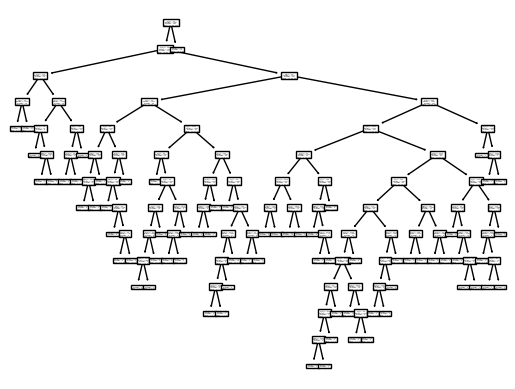

In [14]:
#Create classifiers, calculate accuracy for each tree and plot them:
tree_entropy = tree.DecisionTreeClassifier(criterion='entropy').fit(data_train, target_train)
y_pred_entropy = tree_entropy.predict(data_test)
print("Accuracy for entropy tree: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_entropy)
plt.show()

Accuracy for entropy gini:  0.49473684210526314


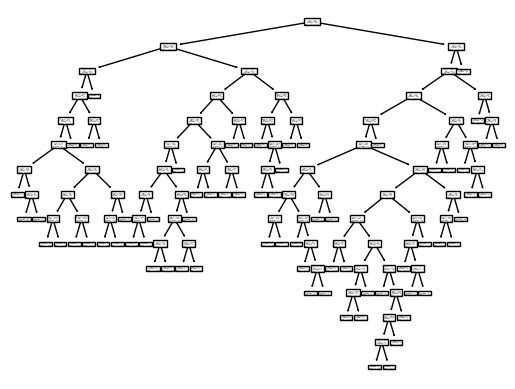

In [15]:
tree_gini = tree.DecisionTreeClassifier(criterion='gini').fit(data_train, target_train)
y_pred_entropy = tree_gini.predict(data_test)
print("Accuracy for entropy gini: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_gini)
plt.show()

Accuracy for entropy log_loss:  0.4105263157894737


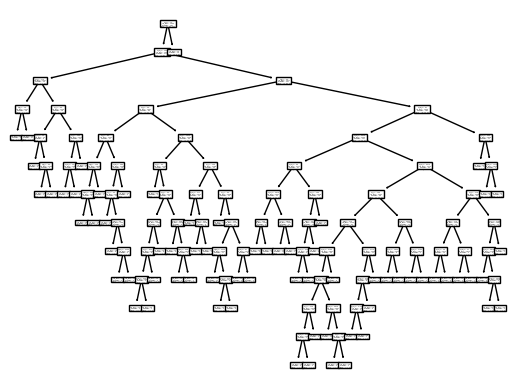

In [16]:
tree_log_loss = tree.DecisionTreeClassifier(criterion='log_loss').fit(data_train, target_train)
y_pred_entropy = tree_log_loss.predict(data_test)
print("Accuracy for entropy log_loss: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_log_loss)
plt.show()

### 2.3 Cost complexity pruning or weakest link pruning

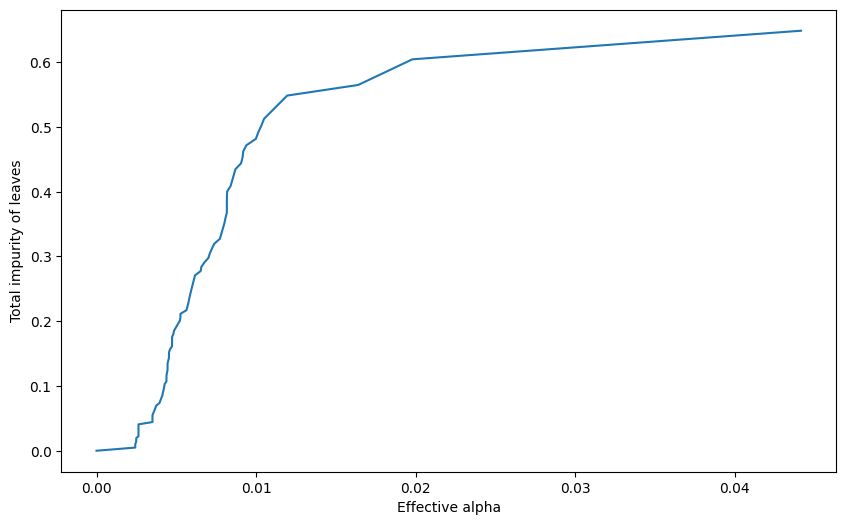

In [17]:
#Let's use a pruning approach based on cost complexity of the path:
clf = tree.DecisionTreeClassifier()
path = clf.cost_complexity_pruning_path(X, Y)


#We will only pick those trees which are indexed by this alpha. For each alpha value we have a subtree 
#which minimize the error (impurity).
#Let's plot the relation between alpha and impurity:

ccp_alphas, impurities = path.ccp_alphas, path.impurities
_ = plt.figure(figsize=(10, 6))
_ = plt.plot(ccp_alphas, impurities)
_ = plt.xlabel("Effective alpha")
_ = plt.ylabel("Total impurity of leaves")
plt.show()

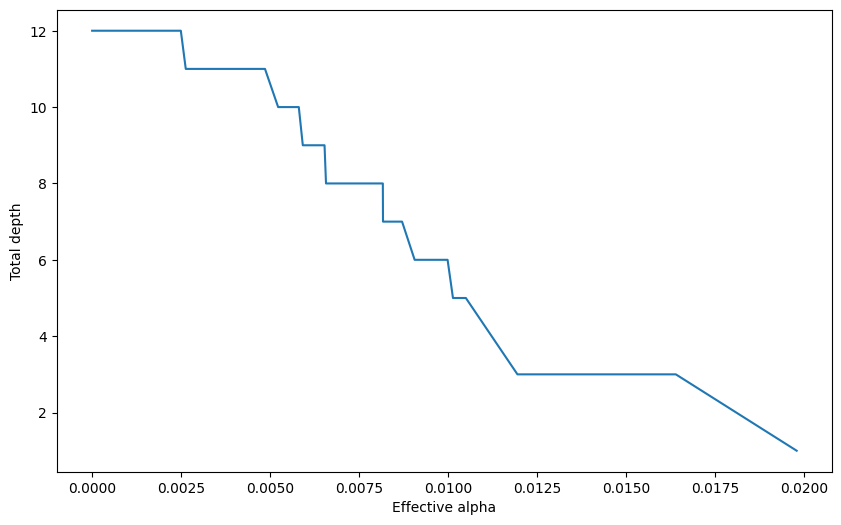

In [18]:
#Let's find the optimal value for alpha using a Decision Tree which uses the alpha coefficients:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X, Y)
    clfs.append(clf)

#We also have a relation between alpha and the depth of the tree. Let's plot it:
tree_depths = [clf.tree_.max_depth for clf in clfs]
_ = plt.figure(figsize=(10,  6))
_ = plt.plot(ccp_alphas[:-1], tree_depths[:-1])
_ = plt.xlabel("Effective alpha")
_ = plt.ylabel("Total depth")
plt.show()

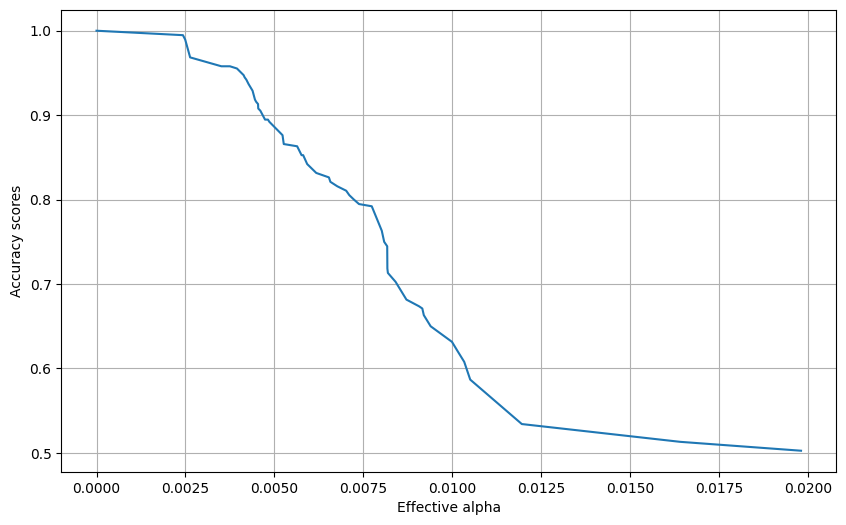

In [19]:
#Finally, let's observe the relation between accuracy and the alpha coefficient. To do this, 
# we predict the accuracy for all alpha values:
acc_scores = [accuracy_score(Y, clf.predict(X)) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
_ = plt.figure(figsize=(10,  6))
_ = plt.grid()
_ = plt.plot(ccp_alphas[:-1], acc_scores[:-1])
_ = plt.xlabel("Effective alpha")
_ = plt.ylabel("Accuracy scores")
plt.show()

We can see that for an effective alpha of 0.0100 - 0.0125 which means maximum depth of 4, we have a somewhat superior accuracy to what we obtained without pruning.
Let's compute the accuracy again with this max_depth to see if the decission tree is now more accurate with unseen cases:

Accuracy for entropy tree prunned:  0.5052631578947369


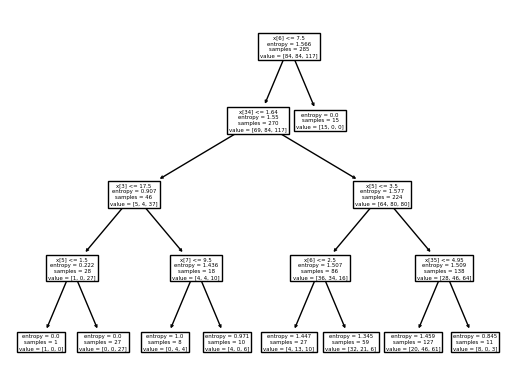

In [20]:
tree_entropy_prun = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(data_train, target_train)
y_pred_entropy = tree_entropy_prun.predict(data_test)
print("Accuracy for entropy tree prunned: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_entropy_prun)
plt.show()

Accuracy for entropy gini prunned:  0.4421052631578947


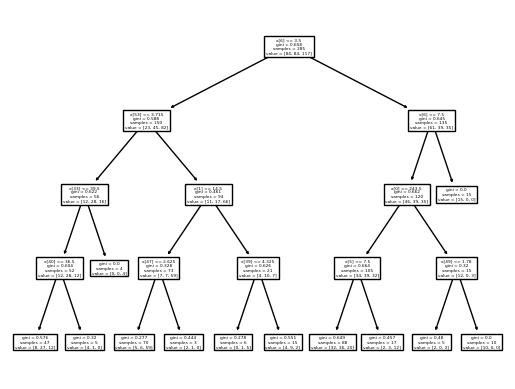

In [21]:
tree_gini_prun = tree.DecisionTreeClassifier(criterion='gini', max_depth=4).fit(data_train, target_train)
y_pred_entropy = tree_gini_prun.predict(data_test)
print("Accuracy for entropy gini prunned: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_gini_prun)
plt.show()

Accuracy for entropy log_loss prunned:  0.5052631578947369


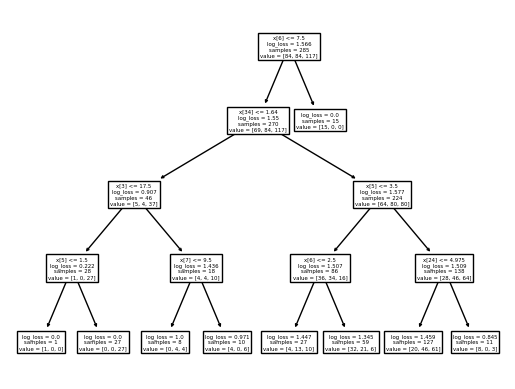

In [22]:
tree_log_loss_prun = tree.DecisionTreeClassifier(criterion='log_loss', max_depth=4).fit(data_train, target_train)
y_pred_entropy = tree_log_loss_prun.predict(data_test)
print("Accuracy for entropy log_loss prunned: ", accuracy_score(target_test, y_pred_entropy))
_ = tree.plot_tree(tree_log_loss_prun)
plt.show()

### 2.4 Using Random Forest with different lengths

The classifier RandomForest() is known for having a good result in accuracy since it combines multiple DecisionTrees to reach a single result. Let's see if we manage to improve our prediction accuracy:

In [23]:
# Now we follow the same steps as before:
#Create classifiers, calculate accuracy for each forest:
forest_entropy = RandomForestClassifier(criterion='entropy').fit(data_train, target_train)
y_pred_entropy = forest_entropy.predict(data_test)
print("Accuracy for entropy random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_gini = RandomForestClassifier(criterion='gini').fit(data_train, target_train)
y_pred_entropy = forest_gini.predict(data_test)
print("Accuracy for gini random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_log_loss = RandomForestClassifier(criterion='log_loss').fit(data_train, target_train)
y_pred_entropy = forest_log_loss.predict(data_test)
print("Accuracy for log loss random forest of 100 tress: ", accuracy_score(target_test, y_pred_entropy))

Accuracy for entropy random forest of 100 trees:  0.5263157894736842
Accuracy for gini random forest of 100 trees:  0.5052631578947369
Accuracy for log loss random forest of 100 tress:  0.49473684210526314


Let's increase the number of trees in the forest to 1000:

In [24]:
forest_entropy = RandomForestClassifier(n_estimators=500,criterion='entropy').fit(data_train, target_train)
y_pred_entropy = forest_entropy.predict(data_test)
print("Accuracy for entropy random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_gini = RandomForestClassifier(n_estimators=500,criterion='gini').fit(data_train, target_train)
y_pred_entropy = forest_gini.predict(data_test)
print("Accuracy for gini random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_log_loss = RandomForestClassifier(n_estimators=500,criterion='log_loss').fit(data_train, target_train)
y_pred_entropy = forest_log_loss.predict(data_test)
print("Accuracy for log loss random forest of 100 tress: ", accuracy_score(target_test, y_pred_entropy))

Accuracy for entropy random forest of 100 trees:  0.47368421052631576
Accuracy for gini random forest of 100 trees:  0.49473684210526314
Accuracy for log loss random forest of 100 tress:  0.5157894736842106


Let's try post-pruning by decreasing the max depth of the trees:

In [25]:
forest_entropy = RandomForestClassifier(n_estimators=1000,criterion='entropy',max_depth=3).fit(data_train, target_train)
y_pred_entropy = forest_entropy.predict(data_test)
print("Accuracy for entropy random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_gini = RandomForestClassifier(n_estimators=1000,criterion='gini',max_depth=3).fit(data_train, target_train)
y_pred_entropy = forest_gini.predict(data_test)
print("Accuracy for gini random forest of 100 trees: ", accuracy_score(target_test, y_pred_entropy))

forest_log_loss = RandomForestClassifier(n_estimators=1000,criterion='log_loss',max_depth=3).fit(data_train, target_train)
y_pred_entropy = forest_log_loss.predict(data_test)
print("Accuracy for log loss random forest of 100 tress: ", accuracy_score(target_test, y_pred_entropy))

Accuracy for entropy random forest of 100 trees:  0.5368421052631579
Accuracy for gini random forest of 100 trees:  0.5368421052631579
Accuracy for log loss random forest of 100 tress:  0.5473684210526316
